<a href="https://colab.research.google.com/github/Zahra203/Phishing-Detection/blob/main/phishing_detection_(email).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython import get_ipython
from IPython.display import display

In [ ]:
import pandas as pd

In [4]:
import pandas as pd
from google.colab import files
uploaded = files.upload()





Saving SpamAssasin.csv to SpamAssasin.csv


In [5]:
df1 = pd.read_csv("CEAS_08.csv")
df2 = pd.read_csv("Enron.csv")
df3 = pd.read_csv("Ling.csv")
df4 = pd.read_csv("Nazario.csv")
df5 = pd.read_csv("Nigerian_Fraud.csv")
df6 = pd.read_csv("phishing_email.csv")
df7 = pd.read_csv("SpamAssasin.csv")

In [ ]:

def combine_text(df, subject_col, body_col):
    df[subject_col] = df[subject_col].fillna("")
    df[body_col] = df[body_col].fillna("")
    df["text"] = df[subject_col] + " " + df[body_col]
    return df[["text", "label"]]
df1_clean = combine_text(df1, "subject", "body")
df2["label"] = 0
df2_clean = combine_text(df2, "subject", "body")
df3["label"] = 0
df3_clean = combine_text(df3, "subject", "body")
df4["label"] = 1
df4_clean = combine_text(df4, "subject", "body")
df5["label"] = 1
df5_clean = combine_text(df5, "subject", "body")
df6_clean = df6.rename(columns={"text_combined": "text"})[["text", "label"]]
df7_clean = combine_text(df7, "subject", "body")
combined_df = pd.concat([
    df1_clean,
    df2_clean,
    df3_clean,
    df4_clean,
    df5_clean,
    df6_clean,
    df7_clean,
],ignore_index=True)
# Final cleaning
combined_df.dropna(subset=["text"], inplace=True)
combined_df = combined_df[combined_df["text"].str.strip() != ""]
# Shuffle the dataset
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Save to CSV
combined_df.to_csv("combined_email_dataset.csv", index=False)
# Preview
print(combined_df.head())
print(combined_df['label'].value_counts())


                                                text  label
0  open a window to wonderful specials on prescri...      0
1  Re: [Python-Dev] Primer on distributed revisio...      0
2  messom chris kptwqqdtmasseyacnz hi tony format...      0
3  dustin defoe mtqocpdustindefoecom love impleme...      0
4  Adobe Acrobat Reader Security update Adobe Rea...      1
label
0    93624
1    71347
Name: count, dtype: int64


In [ ]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Set up stopwords with phishing-related terms
default_stopwords = set(stopwords.words('english'))
phishing_keywords = {'verify', 'account', 'login', 'click', 'urgent', 'password', 'bank', 'suspend', 'update'}
all_stopwords = default_stopwords.union(phishing_keywords)

def preprocess_email_fast(text):
    try:
        text = str(text)
        text = BeautifulSoup(text, 'html.parser').get_text()        # Remove HTML
        text = text.lower()                                         # Lowercase
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)         # Remove URLs
        text = re.sub(r'[^a-z\s]', '', text)                        # Remove punctuation/numbers
        words = text.split()
        words = [w for w in words if w not in all_stopwords]        # Remove stopwords
        return ' '.join(words)
    except:
        return ''


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Set up stopwords with phishing-related terms
default_stopwords = set(stopwords.words('english'))
phishing_keywords = {'verify', 'account', 'login', 'click', 'urgent', 'password', 'bank', 'suspend', 'update'}
all_stopwords = default_stopwords.union(phishing_keywords)

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocess_email_fast(text):
    try:
        text = str(text)
        text = BeautifulSoup(text, 'html.parser').get_text()
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'[^a-z\s]', '', text)
        words = text.split()
        words = [lemmatizer.lemmatize(w) for w in words if w not in all_stopwords]
        return ' '.join(words)
    except:
        return ''


# 1. Load dataset
df = pd.read_csv("combined_email_dataset.csv")

# 2. Apply text cleaning
df['clean_text'] = df['text'].apply(preprocess_email_fast)

print("Dataset loaded and text cleaning applied.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset loaded and text cleaning applied.


In [ ]:
print("Label distribution:\n", df['label'].value_counts())

Label distribution:
 label
0    93624
1    71347
Name: count, dtype: int64


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 3. Vectorize with TF-IDF including bigrams
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['clean_text'])

print("Text vectorized using TF-IDF.")

Text vectorized using TF-IDF.


In [ ]:
joblib.dump(vectorizer, "email_vectorizer.joblib")
print("Vectorizer saved")

Vectorizer saved


In [ ]:
!pip install xgboost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# Split features and labels
# This line requires the 'df' DataFrame to be defined
y = df['label']

# Print class balance
print("Label distribution:\n", y.value_counts())

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, stratify=y)

# Train Random Forest with balanced classes
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Starting Random Forest training...")
model.fit(X_train, y_train)
print("Random Forest training complete.")

# Evaluate Random Forest
print("\nRandom Forest Evaluation:")
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Optional: Train and evaluate XGBoost
print("\nTraining XGBoost model...")
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

print("\nXGBoost Evaluation:")
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Label distribution:
 label
0    93624
1    71347
Name: count, dtype: int64
Starting Random Forest training...
Random Forest training complete.

Random Forest Evaluation:
Accuracy: 0.8397636005455372
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     18725
           1       0.81      0.82      0.82     14270

    accuracy                           0.84     32995
   macro avg       0.84      0.84      0.84     32995
weighted avg       0.84      0.84      0.84     32995


Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:00:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Evaluation:
XGBoost Accuracy: 0.8880436429762085
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     18725
           1       0.85      0.90      0.87     14270

    accuracy                           0.89     32995
   macro avg       0.89      0.89      0.89     32995
weighted avg       0.89      0.89      0.89     32995



In [ ]:
# Get predicted and actual values
y_pred = model.predict(X_test)

# Add predictions back to test DataFrame
X_test_df = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())
test_results = df.iloc[y_test.index].copy()  # original test rows

# Assign the numpy array directly
test_results["predicted"] = y_pred
# Assign the pandas Series directly
test_results["actual"] = y_test

# Find mistakes
false_positives = test_results[(test_results["actual"] == 0) & (test_results["predicted"] == 1)]
false_negatives = test_results[(test_results["actual"] == 1) & (test_results["predicted"] == 0)]

# Save them for manual review
false_positives.to_csv("false_positives.csv", index=False)
false_negatives.to_csv("false_negatives.csv", index=False)

# Show basic stats
print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

False Positives: 2679
False Negatives: 2608


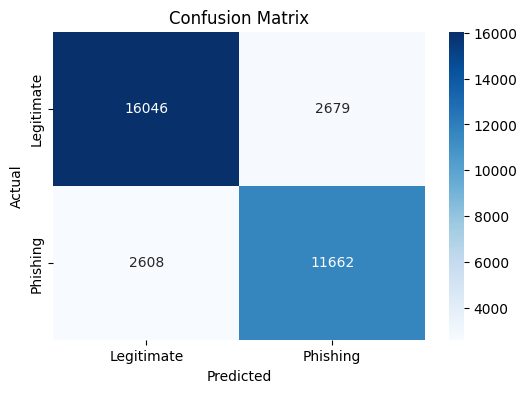

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


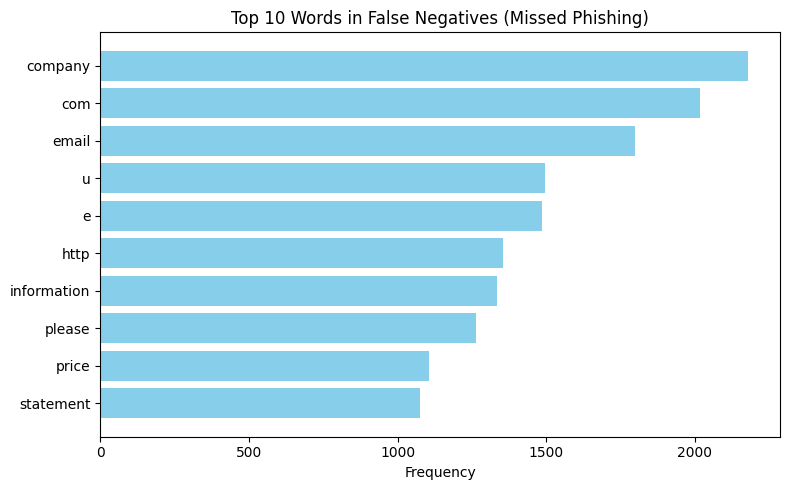

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Split all words from false negatives
all_words = " ".join(false_negatives['clean_text']).split()
word_counts = Counter(all_words)

# Get top 10
top_words = word_counts.most_common(10)
words, counts = zip(*top_words)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(words, counts, color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 10 Words in False Negatives (Missed Phishing)")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


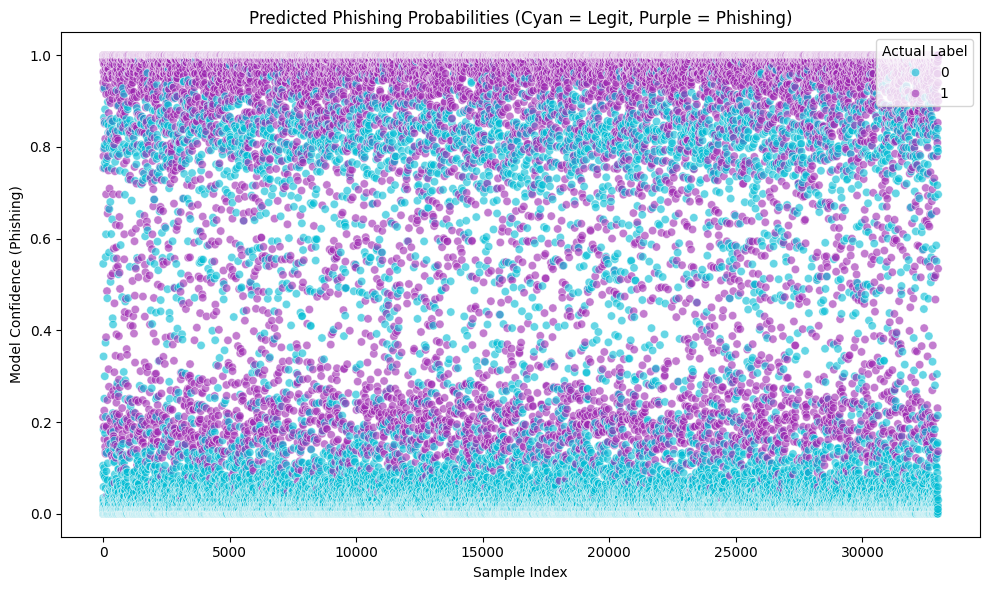

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assign predicted probabilities if not already done
test_results['prob_phishing'] = model.predict_proba(X_test)[:, 1]

# Use cooler colors: cyan for legit (0), purple for phishing (1)
palette = {0: '#00bcd4', 1: '#9c27b0'}  # Cyan & Purple

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=range(len(test_results)),
    y='prob_phishing',
    hue='actual',
    data=test_results,
    palette=palette,
    alpha=0.6
)
plt.title("Predicted Phishing Probabilities (Cyan = Legit, Purple = Phishing)")
plt.ylabel("Model Confidence (Phishing)")
plt.xlabel("Sample Index")
plt.legend(title="Actual Label", loc="upper right")
plt.tight_layout()
plt.show()


In [ ]:
!pip install joblib

In [ ]:
import joblib

# Define the filename for your model
model_filename = 'random_forest_phishing_model(email).joblib'

# Save the model to the file
joblib.dump(model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to random_forest_phishing_model(email).joblib


In [ ]:
import pandas as pd
from pprint import pprint

# Load your dataset (replace with actual filename if needed)
# df = pd.read_csv("combined_email_dataset.csv") # This line is already executed above

# The columns 'url' and 'status' do not exist in df based on previous steps.
# Remove the line attempting to drop them.
# df_features = df.drop(columns=["url", "status"]) # REMOVED

# Get the column names that actually exist in df
feature_names = df.columns.tolist()

# Pretty print the list
pprint(feature_names)

['text', 'label', 'clean_text']


In [ ]:
from google.colab import files
files.download("random_forest_phishing_model(email).joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("email_vectorizer.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>